In [1]:
import sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import rfpimp
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline, make_union
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble.forest import _generate_unsampled_indices
from sklearn.metrics import (accuracy_score,
                             roc_auc_score,
                             confusion_matrix,
                             classification_report,
                             r2_score)
from sklearn.model_selection import (train_test_split,
                                     cross_val_score,
                                     StratifiedKFold,
                                     GridSearchCV,
                                     RandomizedSearchCV)
sys.path.append('../')
import utils

%matplotlib inline
sns.set_context('notebook')
plt.style.use('fivethirtyeight')

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
df = pd.read_csv('../data/rent.txt')
df.head()

,bathrooms,bedrooms,price,longitude,latitude,interest_level
0,1.5,3,3000,-73.9425,40.7145,2
1,1.0,2,5465,-73.9667,40.7947,1
2,1.0,1,2850,-74.0018,40.7388,3
3,1.0,1,3275,-73.9677,40.7539,1
4,1.0,4,3350,-73.9493,40.8241,1


In [4]:
# Convert to numpy
X_train = df.drop(['interest_level'], axis=1).values
y_train = df['interest_level'].values
y_train = pd.Series(y_train).map({1: 0, 2: 1, 3: 2}).values
features = df.columns[:-1]
print(f'Shape : {X_train.shape}, {y_train.shape}')

Shape : (49352, 5), (49352,)


In [5]:
# Create CV object
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

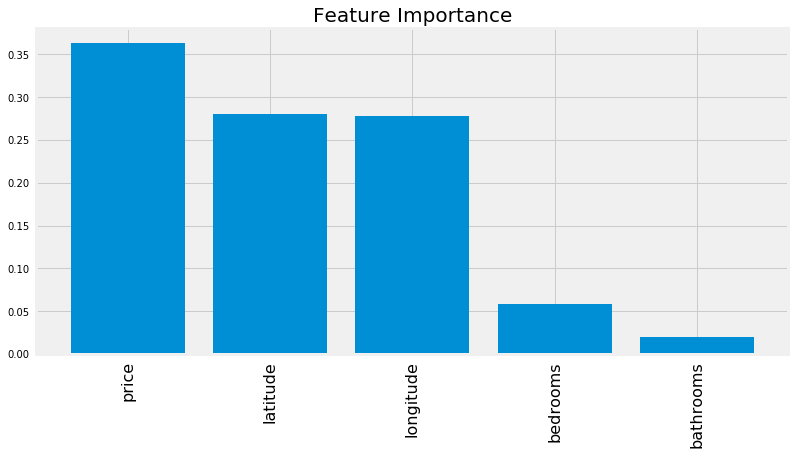

In [6]:
rf_clf = RandomForestClassifier(n_estimators=100,
                                class_weight='balanced',
                                random_state=1,
                                oob_score=True)
rf_clf.fit(X_train, y_train)
utils.utils.plot_feature_imp(rf_clf, feature_names=features)

In [93]:
def oob_accuracy(rf_clf, X_train, y_train):
    n_samples = X_train.shape[0]
    n_classes = len(np.bincount(y_train))
    preds_matrix = np.zeros((n_samples, n_classes))
    
    # Iterate over all trees
    for tree in rf_clf.estimators_:
        # Generate unsampled indices
        unsampled_idxs = _generate_unsampled_indices(tree.random_state, n_samples)
        preds = tree.predict_proba(X_train[unsampled_idxs, :])
        preds_matrix[unsampled_idxs, :] += preds
    
    preds_classes = np.argmax(preds_matrix, axis=1)
    oob_score = (y_train == preds_classes).mean()
    return oob_score


def oob_r2(rf_reg, X_train, y_train):
    n_samples = X_train.shape[0]
    n_preds = np.zeros(n_samples)
    preds_matrix = np.zeros((n_samples))
    
    # Iterate over all trees
    for tree in rf_reg.estimators_:
        # Generate unsampled indices
        unsampled_idxs = _generate_unsampled_indices(tree.random_state, n_samples)
        preds = tree.predict(X_train[unsampled_idxs, :])
        preds_matrix[unsampled_idxs] += preds
        n_preds[unsampled_idxs] += 1
    
    # Avoid dividing by zero if some samples weren't included
    if (n_preds == 0).any():
        warnings.warn("Some features didn't have OOB samples.")
        # Discard samples weren't OOB in any feature
        y_train = y_train[n_preds != 0]
        preds_matrix = preds_matrix[n_preds != 0]
        avg_preds = preds_matrix / n_preds
        oob_score = r2_score(y_train, avg_preds, )
        return oob_score


def permutation_importances(rf_clf, X_train, y_train, scorer):
    feat_imp = []
    baseline_score = scorer(rf_clf, X_train, y_train)
    for j in range(X_train.shape[1]):
        temp = X_train[:, j].copy()
        X_train[:, j] = np.random.permutation(X_train[:, j])
        score = scorer(rf_clf, X_train, y_train)
        feat_imp.append(baseline_score - score)
        X_train[:, j] = temp
    return np.array(feat_imp)

In [19]:
import warnings

In [112]:
oob_accuracy(rf_clf, X_train, y_train)

0.8792372881355932

In [113]:
perm_imp = permutation_importances(rf_clf, X_train, y_train, oob_accuracy)
perm_imp

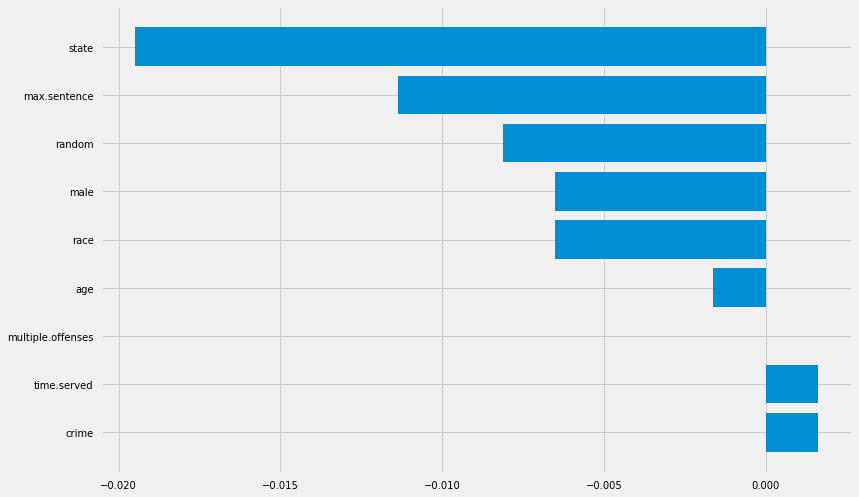

In [137]:
idxs = np.argsort(perm_imp)[::-1]
plt.figure(figsize=(12, 8))
plt.barh(range(9), perm_imp[idxs])
plt.yticks(range(9), features[idxs]);

In [171]:
base_rf = RandomForestClassifier(n_estimators=100,
                                 min_samples_leaf=5,
                                 n_jobs=-1,
                                 oob_score=True)
rf_clf = clone(base_rf)
rf_clf.fit(X_train, y_train)
oob = oob_accuracy(rf_clf, X_train, y_train)
print("oob accuracy",oob)

imp = permutation_importances(rf_clf, X_train, y_train,
                              oob_accuracy)

oob accuracy 0.7177824606905495


In [172]:
imp

array([0.00382963, 0.10165748, 0.14175717, 0.03363592, 0.03250122])

In [156]:
np.unique(pd.Series(y_train).map({1: 0, 2: 1, 3: 2}))

array([0, 1, 2])

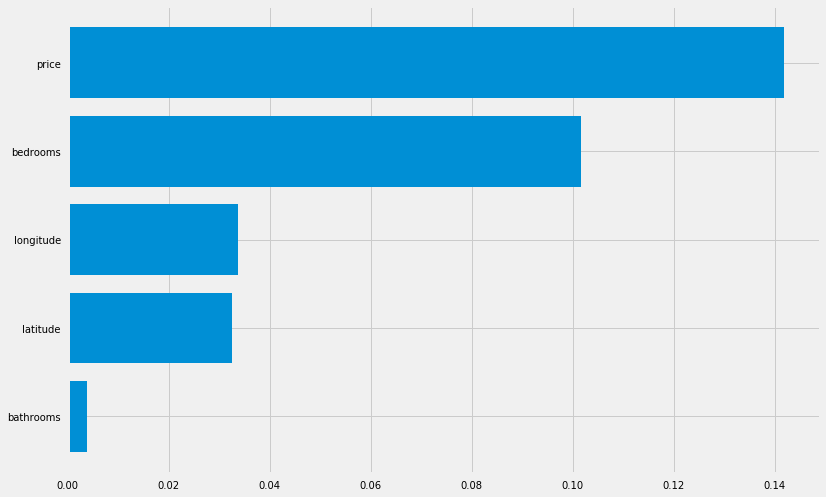

In [180]:
idxs = np.argsort(imp)
plt.figure(figsize=(12, 8))
plt.barh(range(5), imp[idxs])
plt.yticks(range(5), df.columns[:-1][idxs]);